This code fits a multi-output plynomial regression model to predict the meshed dendritic field, effectively training one polynomial regression model per pixel. The model achieves low MSE on both training and testing sets, visual reconstruction of the predicted images a good performance overall. Further investigation are done on the results.


Polynomial degree is a hyperparameter than was tuned by trial and error.

In [12]:
# Cell 0

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import re


In [2]:
# Cell 2

# Load the 250x250 data
import numpy as np

X_train = np.load('X_train.npy')
y_train = np.load('Y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('Y_test.npy')

# Flatten outputs
y_train_flat = y_train.reshape(y_train.shape[0], -1)
y_test_flat = y_test.reshape(y_test.shape[0], -1)

print(X_train.shape, y_train_flat.shape)
print(X_test.shape, y_test_flat.shape)


(200, 5) (200, 62500)
(51, 5) (51, 62500)


In [3]:
# Cell 3
# Creat a function to fit a polynomial regression of degree k 7 both training as well as testing MSEs
# The function also plots a residual plot for residual analysis

def polynomial_regression_250(degree_k, X_train, y_train_flat, X_test, y_test_flat):
    """
    Perform polynomial regression of degree k on 250x250 dataset.
    Returns the model and the fitted PolynomialFeatures object.
    """
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree_k)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Fit the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_flat)
    
    # Predict
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    y_train_pred = np.clip(y_train_pred, 0, 1)
    y_test_pred = np.clip(y_test_pred, 0, 1)


    
    # Residuals
    residuals_train = (y_train_flat - y_train_pred).flatten()
    residuals_test = (y_test_flat - y_test_pred).flatten()

    # Mean residuals per sample
    mean_residual_per_sample = residuals_train.reshape(y_train_flat.shape[0], -1).mean(axis=1)
    
    plt.figure(figsize=(8,6))
    plt.scatter(np.arange(mean_residual_per_sample.shape[0]), mean_residual_per_sample, alpha=0.5, s=5, label=f"E[Residual | X] (Degree {degree_k})")
    plt.axhline(y=0, color='black', linestyle='--', label='Zero Line')
    plt.axhline(y=mean_residual_per_sample.mean(), color='red', linestyle='-', label='Global Mean Residual')
    plt.xlabel('Sample Index')
    plt.ylabel('Mean Residual per Sample')
    plt.title(f'Estimated E[Residual | X] across Training Samples (Degree {degree_k})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print MSEs
    from sklearn.metrics import mean_squared_error
    print(f"Train MSE (Degree {degree_k}): {mean_squared_error(y_train_flat, y_train_pred):.5f}")
    print(f"Test MSE (Degree {degree_k}): {mean_squared_error(y_test_flat, y_test_pred):.5f}")
    
    # Analyze coefficients
    coef_matrix = model.coef_
    mean_abs_coef = np.mean(np.abs(coef_matrix), axis=0)
    
    feature_names = poly.get_feature_names_out()
    degrees = []
    for name in feature_names:
        if name == '1':
            degrees.append(0)
        else:
            degree = sum([int(term.split('^')[1]) if '^' in term else 1 for term in name.split(' ')])
            degrees.append(degree)
    degrees = np.array(degrees)
    
    for d in range(degree_k + 1):
        avg_coef = np.mean(mean_abs_coef[degrees == d])
        print(f"Average |Coefficient| for Degree {d} Terms: {avg_coef:.5e}")
    
    return model, poly 


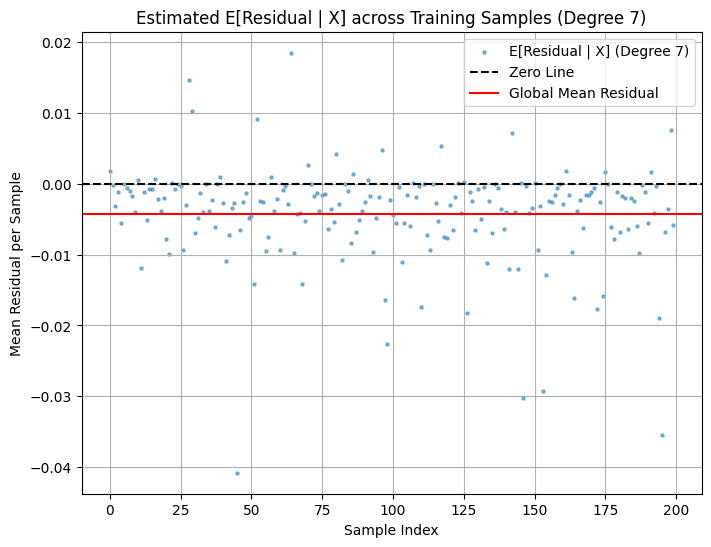

Train MSE (Degree 7): 0.00134
Test MSE (Degree 7): 0.03288
Average |Coefficient| for Degree 0 Terms: 2.70162e-05
Average |Coefficient| for Degree 1 Terms: 3.02173e-04
Average |Coefficient| for Degree 2 Terms: 1.27920e-03
Average |Coefficient| for Degree 3 Terms: 2.26607e-03
Average |Coefficient| for Degree 4 Terms: 3.79638e-03
Average |Coefficient| for Degree 5 Terms: 6.62080e-03
Average |Coefficient| for Degree 6 Terms: 8.70156e-03
Average |Coefficient| for Degree 7 Terms: 6.89921e-03


In [4]:
k = 7
model_degk, poly = polynomial_regression_250(k, X_train, y_train_flat, X_test, y_test_flat)

All the residuals are around 0, which is a good sign. Also, no remarkable outlier.

In [5]:
# Cell 4

def plot_pixel_regressions(model, poly, X_test, y_test_flat, num_pixels=5):
    """
    Pick random pixels, scatter plot true vs predicted values (no lines).
    Two plots per pixel: 1) Sample index scatter; 2) True vs Predicted scatter.
    Adapted for 250x250 outputs (62500 pixels).
    """
    n_pixels = y_test_flat.shape[1]  # total number of pixels
    selected_pixels = np.random.choice(n_pixels, num_pixels, replace=False)
    
    print(f"Selected pixel indices: {selected_pixels}")
    
    # Predict
    X_test_poly = poly.transform(X_test)
    y_test_pred_flat = model.predict(X_test_poly)
    
    for pixel_idx in selected_pixels:
        true_values = y_test_flat[:, pixel_idx]
        pred_values = y_test_pred_flat[:, pixel_idx]
        
        # Create a figure with 2 subplots
        fig, axs = plt.subplots(1, 2, figsize=(14,6))
        
        # First plot: sample index vs true/predicted (SCATTER ONLY)
        axs[0].scatter(np.arange(len(true_values)), true_values, color='blue', alpha=0.5, label='True Data', s=5)
        axs[0].scatter(np.arange(len(pred_values)), pred_values, color='red', alpha=0.5, label='Predicted Data', s=5)
        axs[0].set_xlabel('Sample Index')
        axs[0].set_ylabel('Pixel Value')
        axs[0].set_title(f'Pixel {pixel_idx}: Value vs Sample (Scatter)')
        axs[0].legend()
        axs[0].grid(True)

        # Second plot: true vs predicted scatter
        axs[1].scatter(true_values, pred_values, color='green', alpha=0.5, label='Predicted vs True', s=10)
        axs[1].plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect Prediction (y=x)')
        axs[1].set_xlabel('Ground Truth')
        axs[1].set_ylabel('Prediction')
        axs[1].set_title(f'Pixel {pixel_idx}: Prediction vs True')
        axs[1].legend()
        axs[1].grid(True)
        axs[1].axis('square')
        axs[1].set_xlim(0, 1)
        axs[1].set_ylim(0, 1)

        plt.tight_layout()
        plt.show()


Selected pixel indices: [61404 56019  8632 34816 26864]


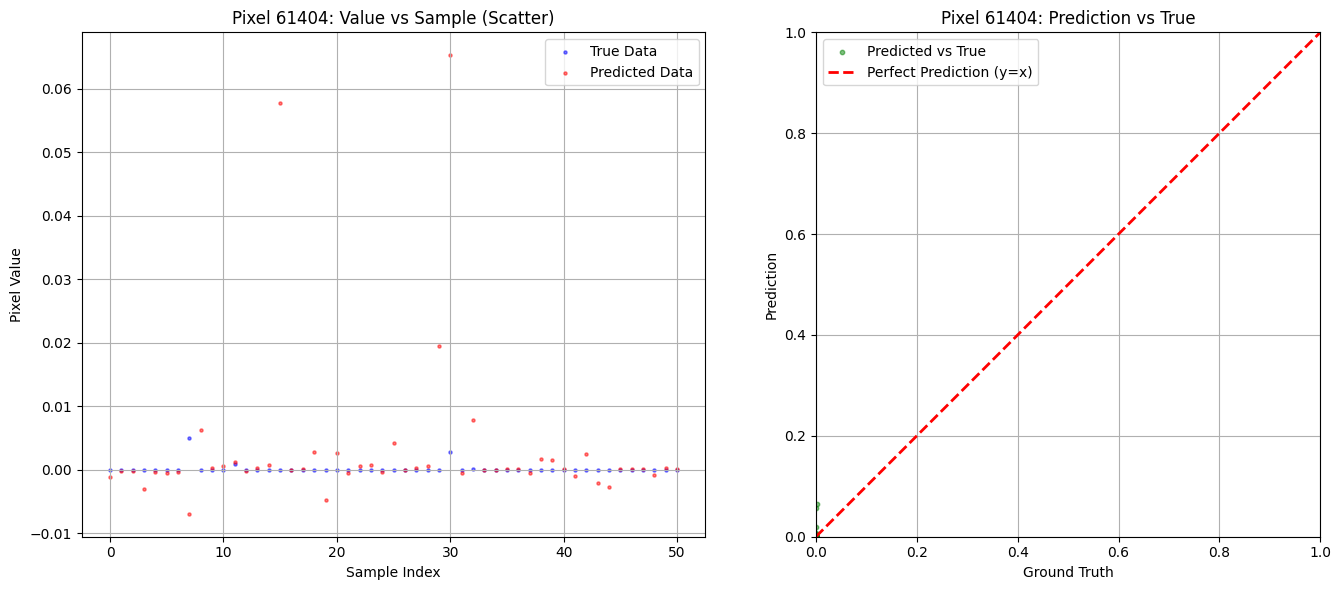

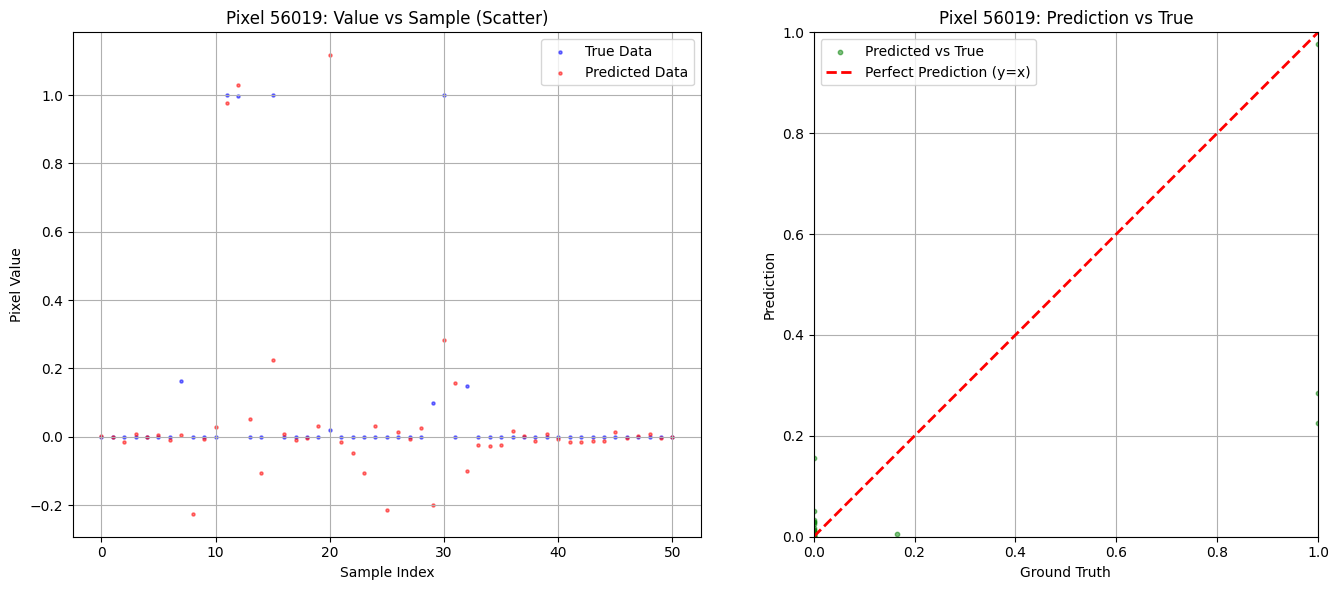

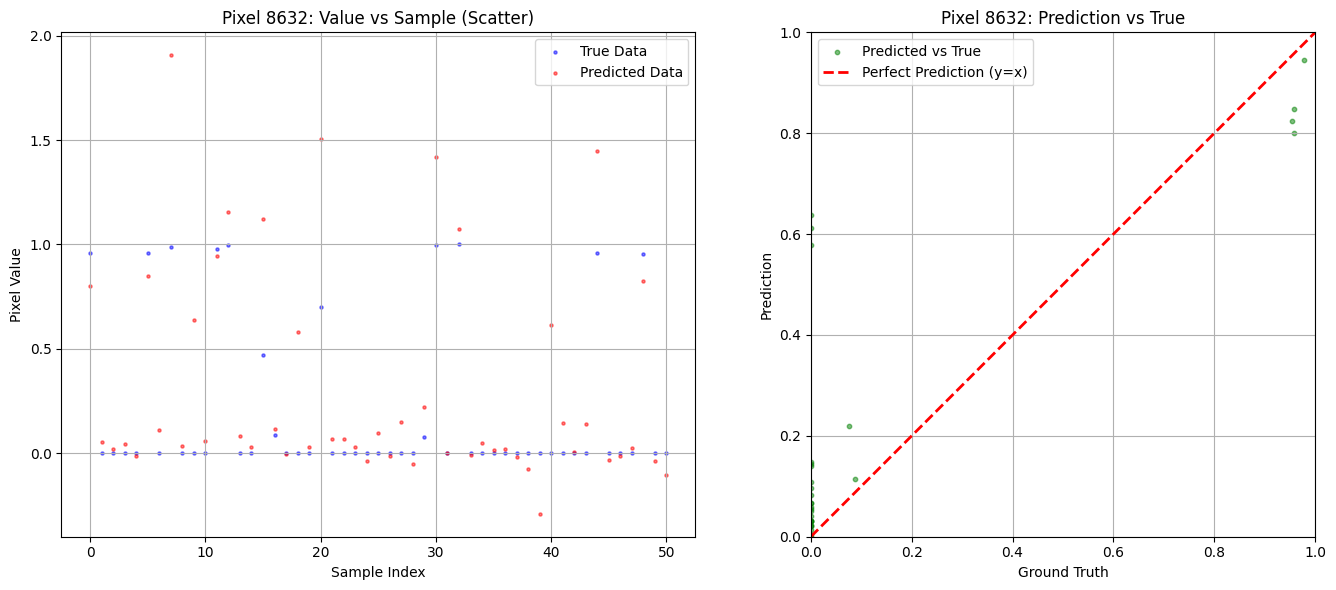

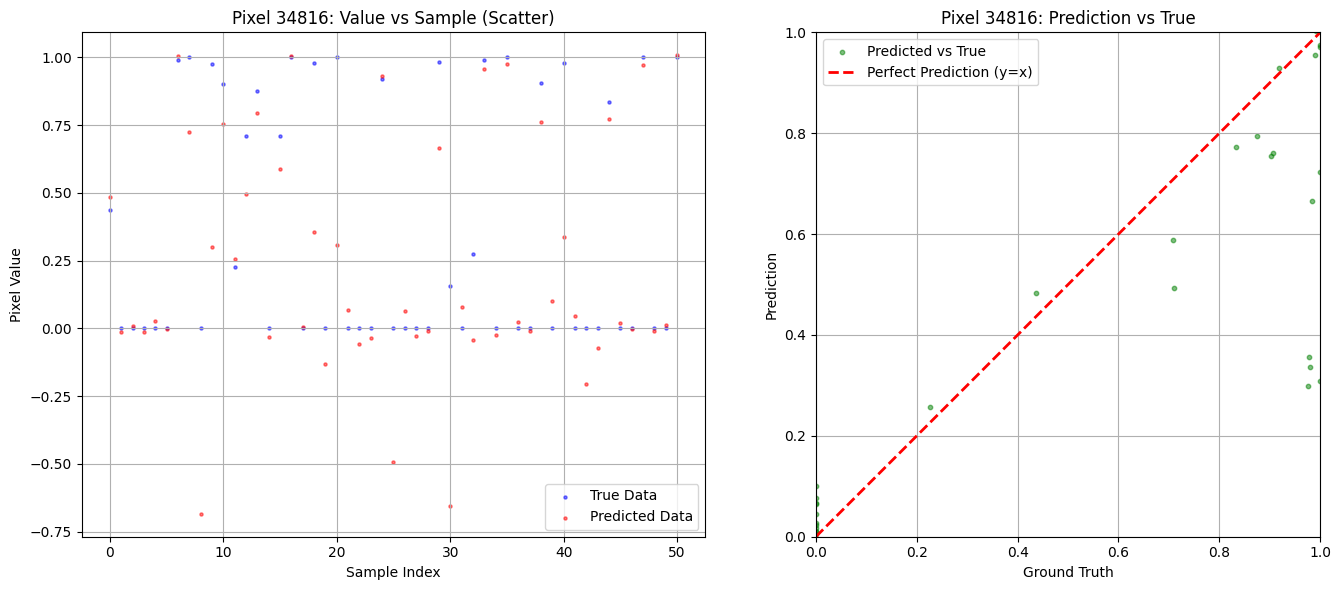

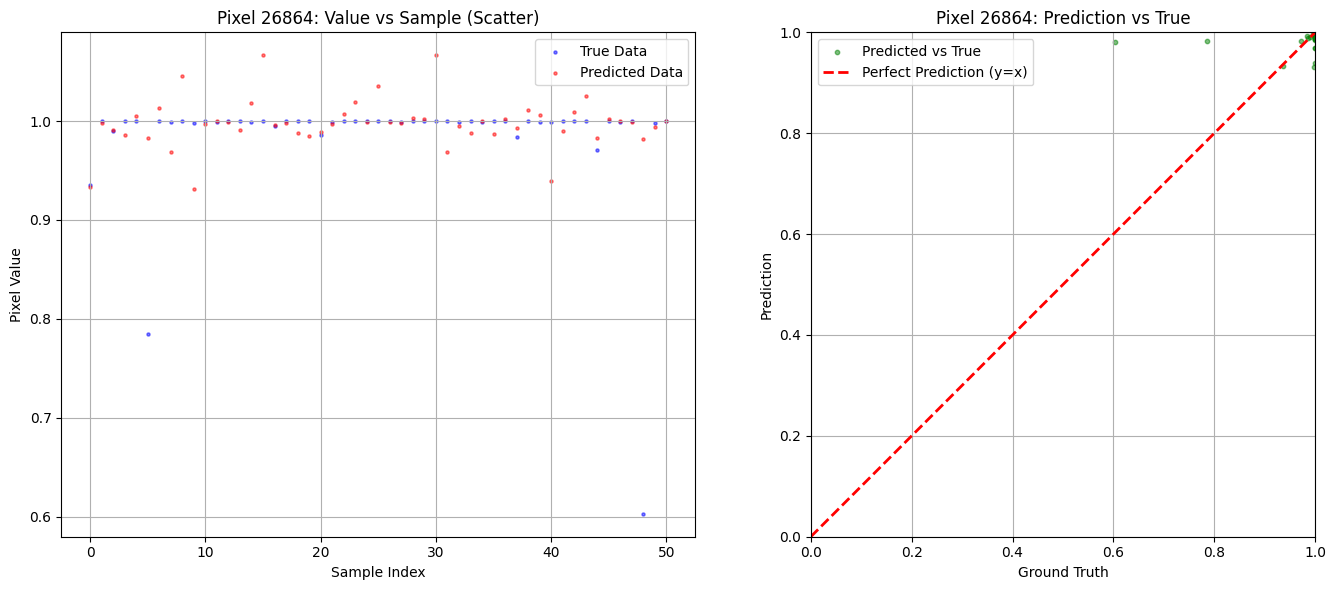

In [6]:
# Cell 5

plot_pixel_regressions(model_degk, poly, X_test, y_test_flat)

In [ ]:
# Cell 6

def reconstruct_predictions_vs_groundtruth_common_scale(model, poly, X_test, y_test_flat, num_samples=5):
    """
    For a few random test samples, reconstruct and plot:
    - Ground truth morphology
    - Predicted morphology
    Side by side, with the SAME color scale across all images.
    """
    # Predict on the test set
    X_test_poly = poly.transform(X_test)
    y_test_pred_flat = model.predict(X_test_poly)
    y_test_pred_flat = model.predict(X_test_poly)
    y_test_pred_flat = np.clip(y_test_pred_flat, 0, 1) 

    
    n_samples = y_test_flat.shape[0]
    n_pixels = y_test_flat.shape[1]
    
    # Randomly select samples
    selected_samples = np.random.choice(n_samples, size=num_samples, replace=False)
    print(f"Selected test sample indices: {selected_samples}")
    
    # First: Find global vmin and vmax across all selected samples (true and predicted)
    vmins = []
    vmaxs = []
    for idx in selected_samples:
        true_image = y_test_flat[idx].reshape(250, 250)
        pred_image = y_test_pred_flat[idx].reshape(250, 250)
        vmins.extend([true_image.min(), pred_image.min()])
        vmaxs.extend([true_image.max(), pred_image.max()])
    
    global_vmin = min(vmins)
    global_vmax = max(vmaxs)
    
    # === Now plot
    for idx in selected_samples:
        true_image = y_test_flat[idx].reshape(250, 250)
        pred_image = y_test_pred_flat[idx].reshape(250, 250)
        
        fig, axs = plt.subplots(1, 2, figsize=(12,5))
        
        # Left: Ground Truth
        im0 = axs[0].imshow(true_image, cmap='viridis', origin='lower', vmin=global_vmin, vmax=global_vmax)
        axs[0].set_title(f'Ground Truth - Sample {idx}')
        axs[0].axis('off')
        fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
        
        # Right: Prediction
        im1 = axs[1].imshow(pred_image, cmap='viridis', origin='lower', vmin=global_vmin, vmax=global_vmax)
        axs[1].set_title(f'Prediction - Sample {idx}')
        axs[1].axis('off')
        fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
        
        plt.tight_layout()
        plt.show()


Selected test sample indices: [38 23 33 12  0]


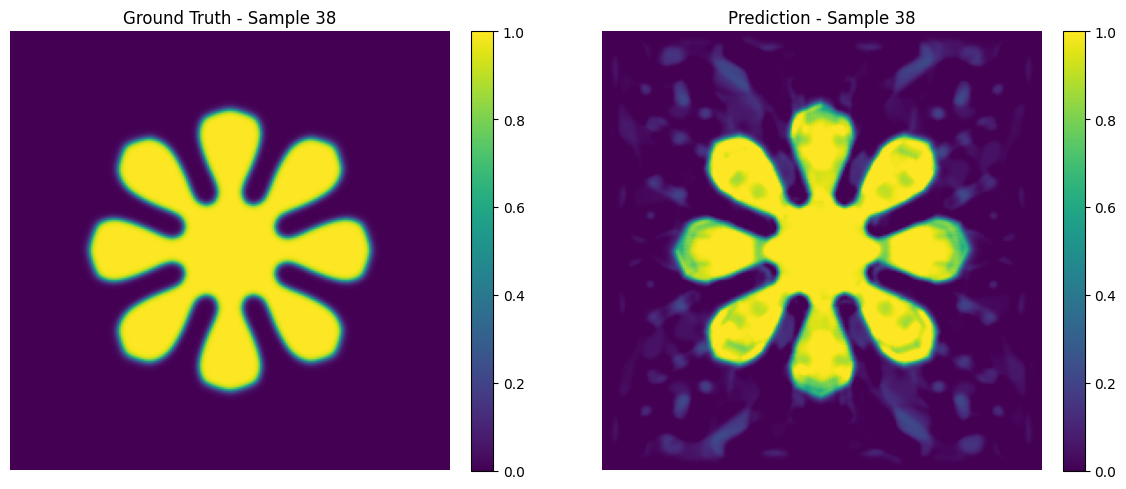

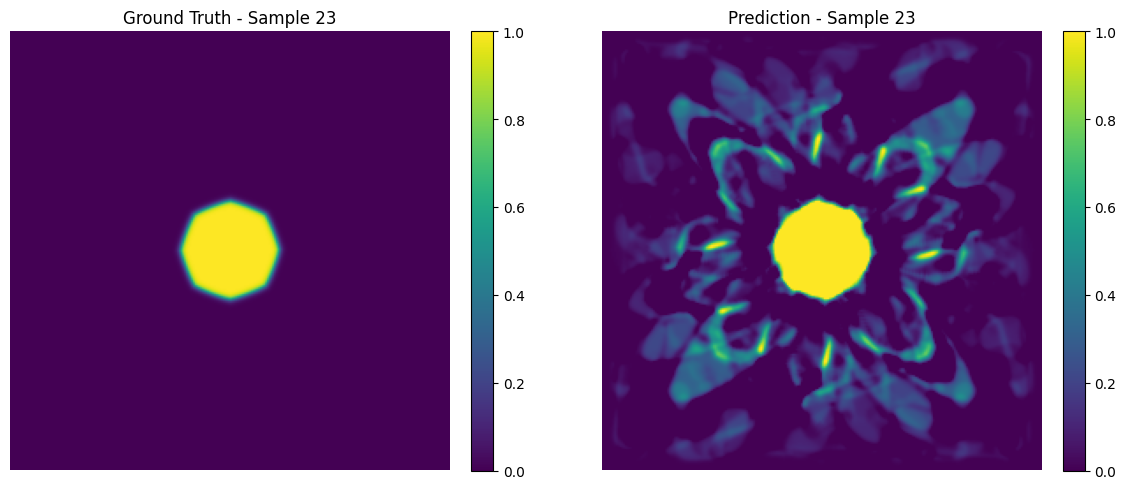

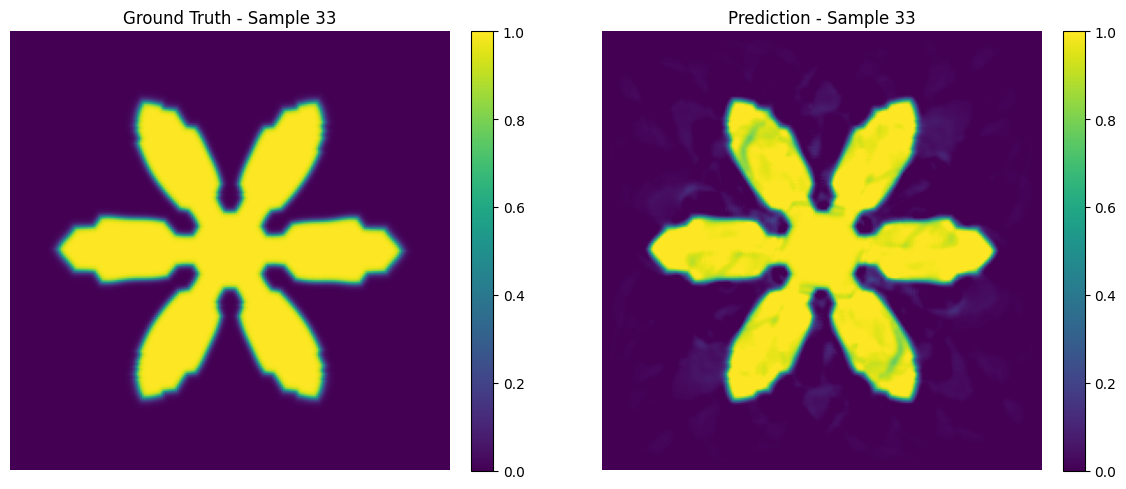

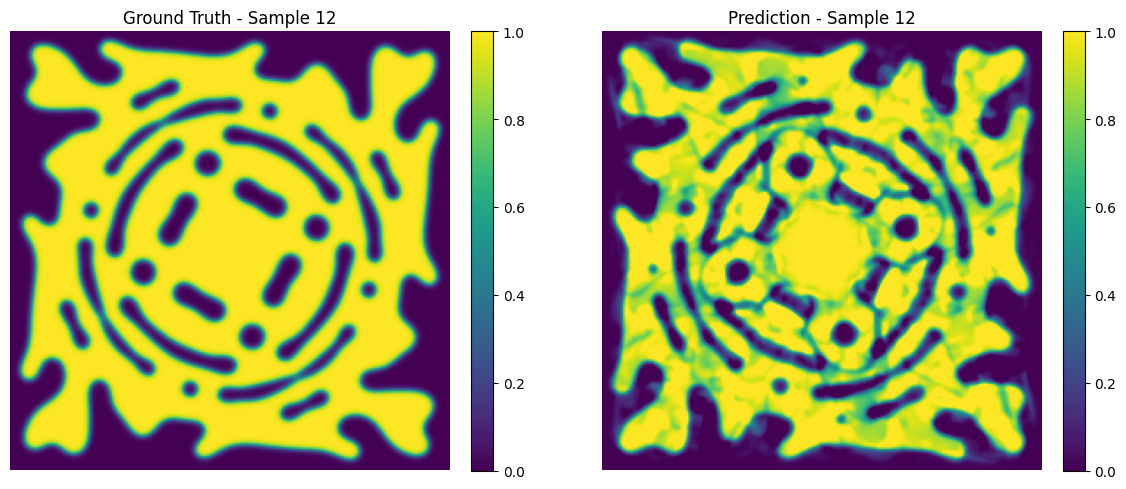

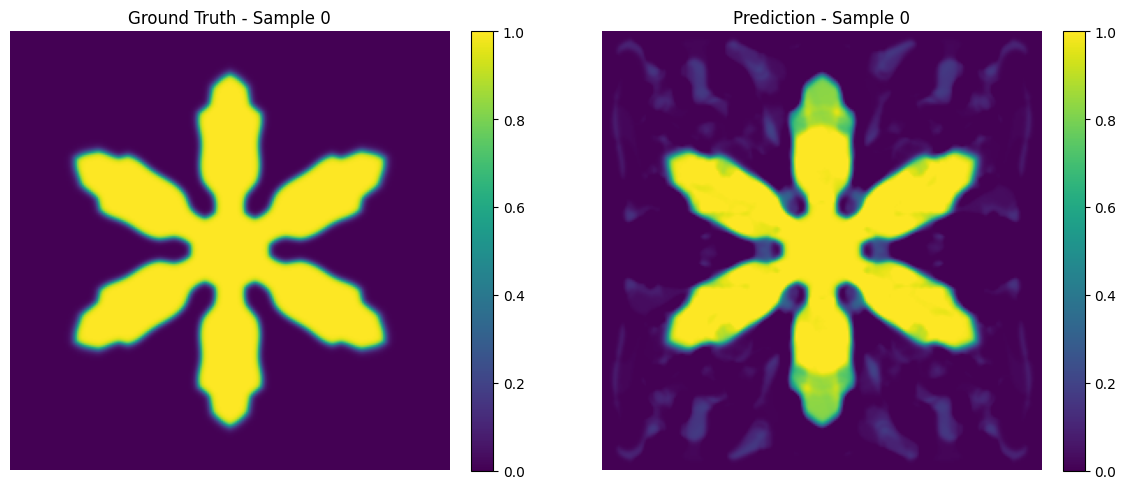

In [ ]:
# Cell 7

reconstruct_predictions_vs_groundtruth_common_scale(model_degk, poly, X_test, y_test_flat)

In [ ]:
# Cell 8

def analyze_svd_from_poly_model(model, poly, field_shape=(250, 250), num_modes=5, top_k=10, input_names=None):
    """
    Analyze and visualize the SVD decomposition of the coefficient matrix from a polynomial regression model.
    
    Includes:
    - Top spatial modes (U columns)
    - Singular value spectrum (S)
    - Input modes (rows of Vᵀ), showing top-k contributors with real input names if given
    """

    # Get the coefficient matrix
    W = model.coef_  # shape: (n_outputs, n_features)
    
    # SVD decomposition
    U, S, Vt = np.linalg.svd(W, full_matrices=False)
    
    # Plot spatial modes (U columns)
    fig, axs = plt.subplots(1, num_modes, figsize=(4 * num_modes, 4))
    vmax = np.max(np.abs(U[:, :num_modes]))  # symmetric color range

    for i in range(num_modes):
        spatial_mode = U[:, i].reshape(field_shape)
        im = axs[i].imshow(spatial_mode, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        axs[i].set_title(f'U Mode {i+1} (Spatial)')
        axs[i].axis('off')

    fig.colorbar(im, ax=axs, orientation='vertical', shrink=0.7, label='Mode Intensity')
    plt.suptitle("Top Spatial Modes (U columns)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Plot singular values (mode energy)
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, num_modes+1), S[:num_modes], marker='o')
    plt.title("Singular Values (Mode Energy)")
    plt.xlabel("Mode")
    plt.ylabel("Singular Value")
    plt.grid(True)
    plt.show()
    
    # Plot input modes (Vᵀ rows, top-k entries)
    feature_labels = poly.get_feature_names_out()

    # Optional: map x0 -> 'dT0', etc.
    if input_names is not None:
        # Create mapping dictionary
        var_map = {f'x{i}': input_names[i] for i in range(len(input_names))}
        
        # Replace in feature labels
        def rename_feature(name):
            for var in var_map:
                name = re.sub(rf'\b{var}\b', var_map[var], name)
            return name
        
        feature_labels = [rename_feature(label) for label in feature_labels]

    fig, axs = plt.subplots(num_modes, 1, figsize=(10, 2.5 * num_modes), constrained_layout=True)

    for i in range(num_modes):
        mode_weights = Vt[i]
        top_indices = np.argsort(np.abs(mode_weights))[-top_k:][::-1]
        top_labels = [feature_labels[j] for j in top_indices]
        top_values = mode_weights[top_indices]
        
        axs[i].bar(top_labels, top_values)
        axs[i].set_title(f"Top {top_k} Input Terms for Mode {i+1}")
        axs[i].set_ylim(-1, 1)
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].grid(True)

    plt.suptitle("Input Modes: Top Polynomial Contributors per SVD Mode", fontsize=16)
    plt.show()


C:\Users\Georges\AppData\Local\Temp\ipykernel_11684\45362921.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


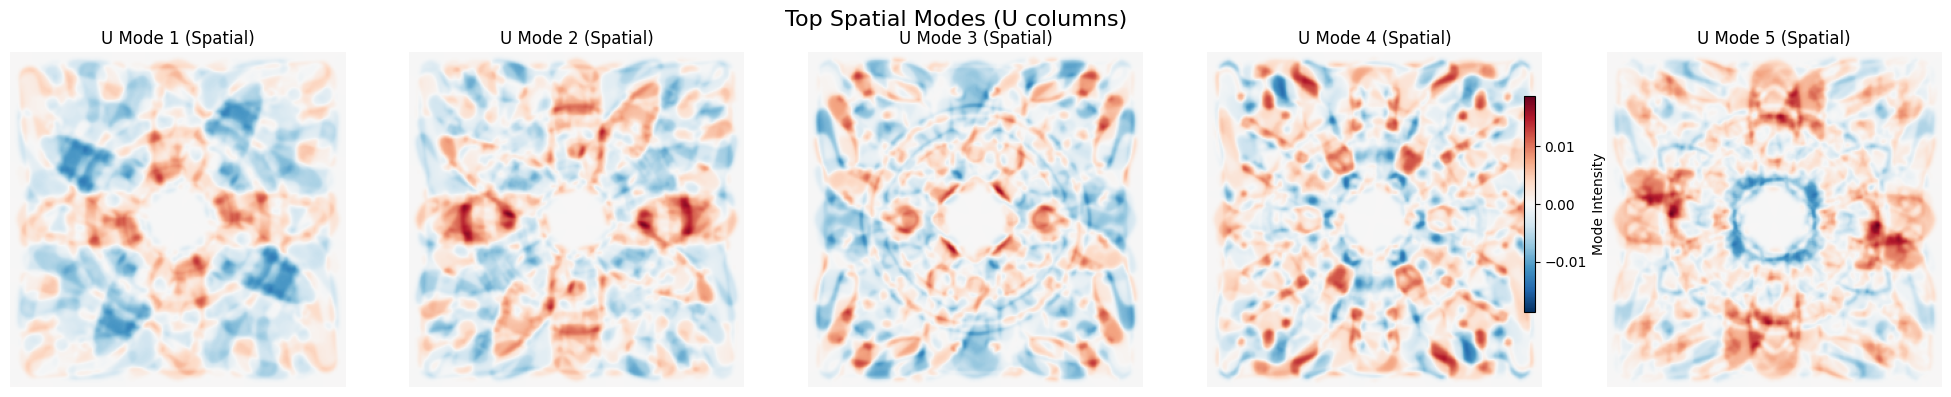

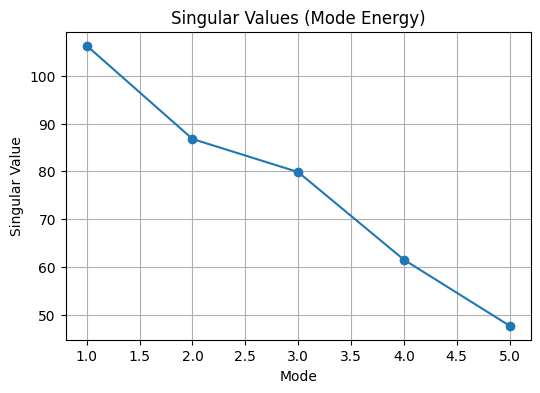

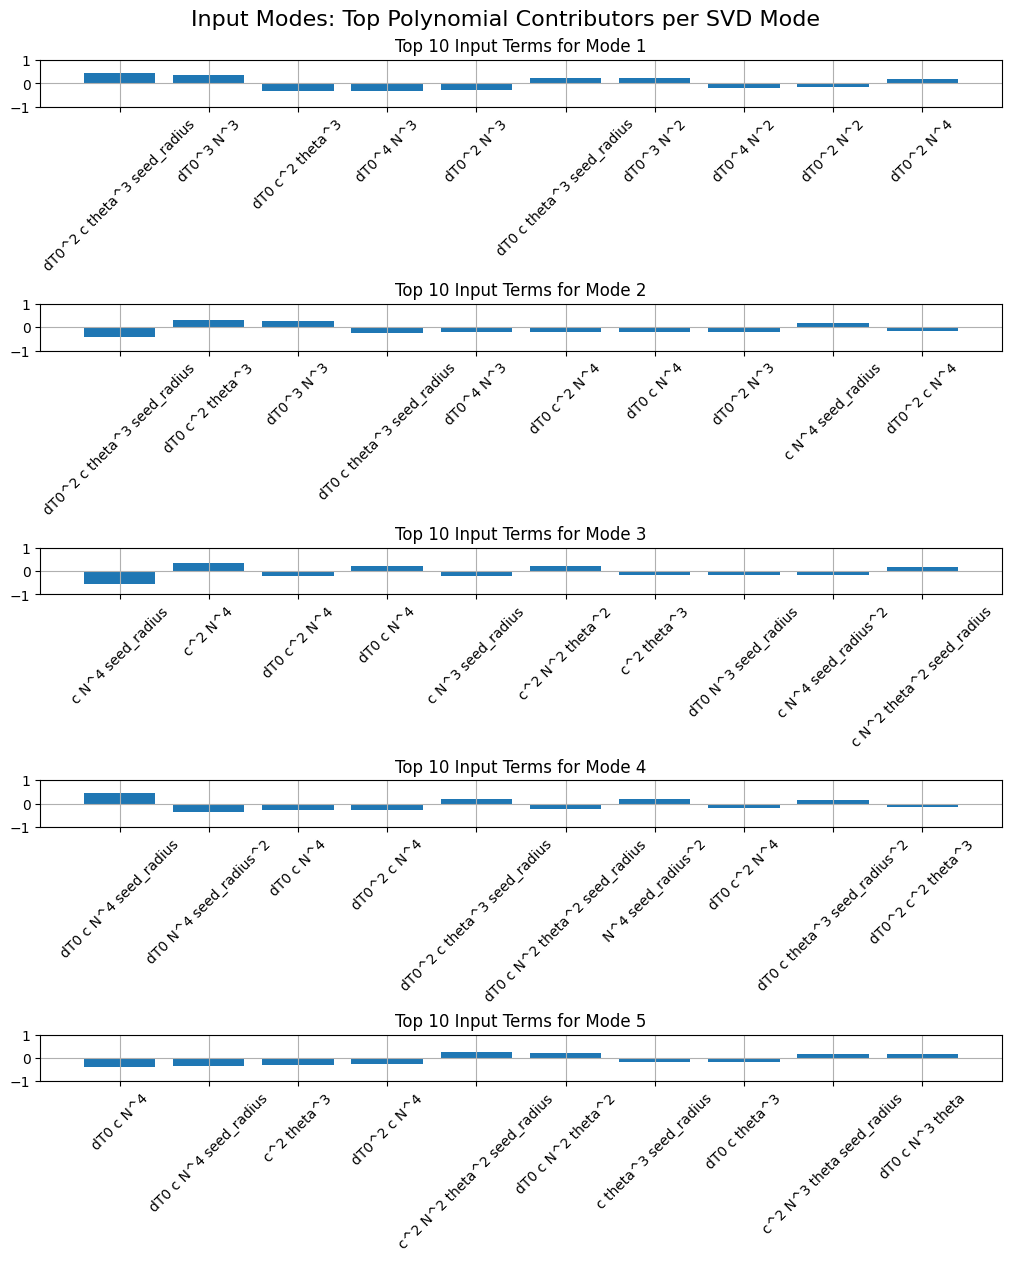

In [52]:
input_names = ['dT0', 'c', 'N', 'theta', 'seed_radius']

analyze_svd_from_poly_model(model_degk, poly, field_shape=(250, 250), num_modes=5, top_k=10, input_names=input_names)


The singular values decrease steadaly in value. Therefore, we can make use of diverse spatial modes. Additionally, the input modes include a wide range of parameters combinations, allowing us to capture nonlinear relations.